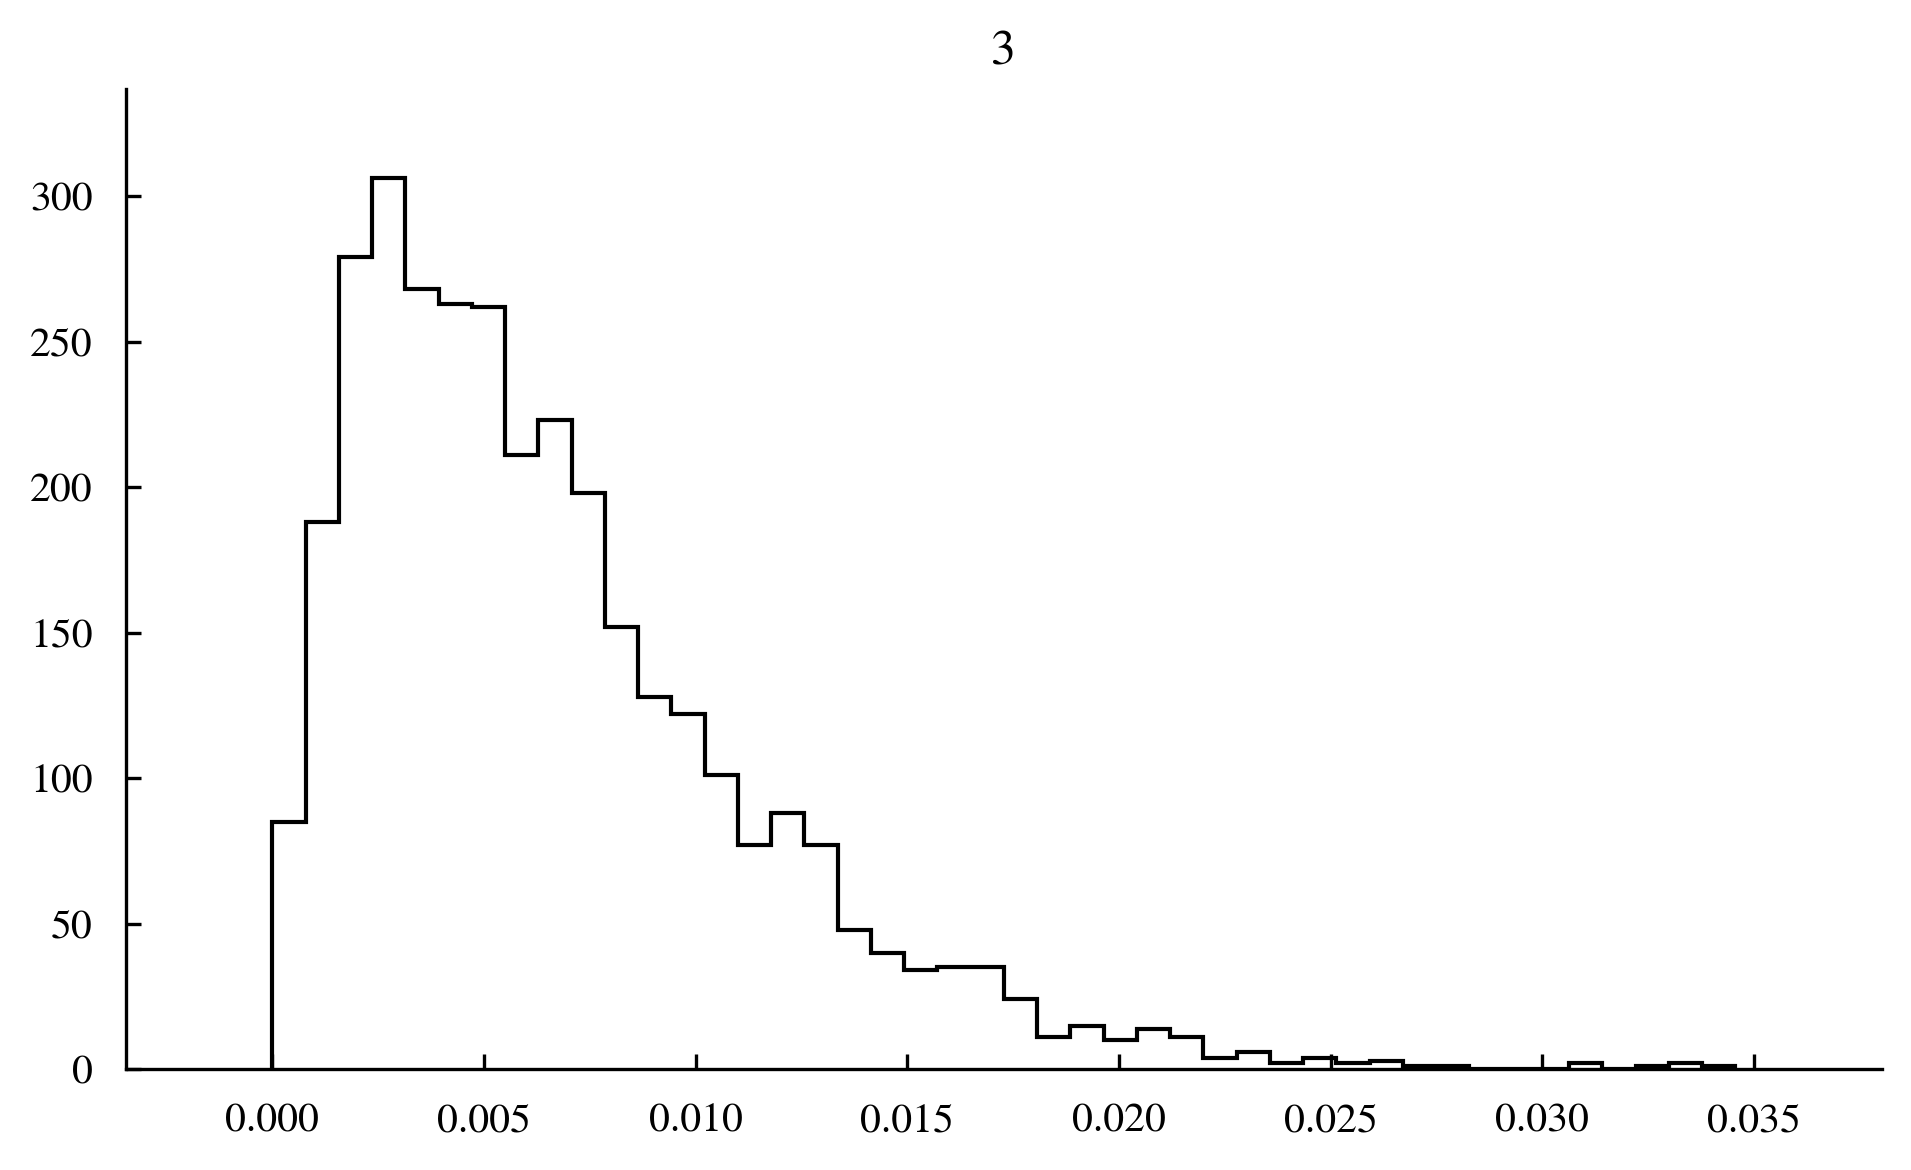

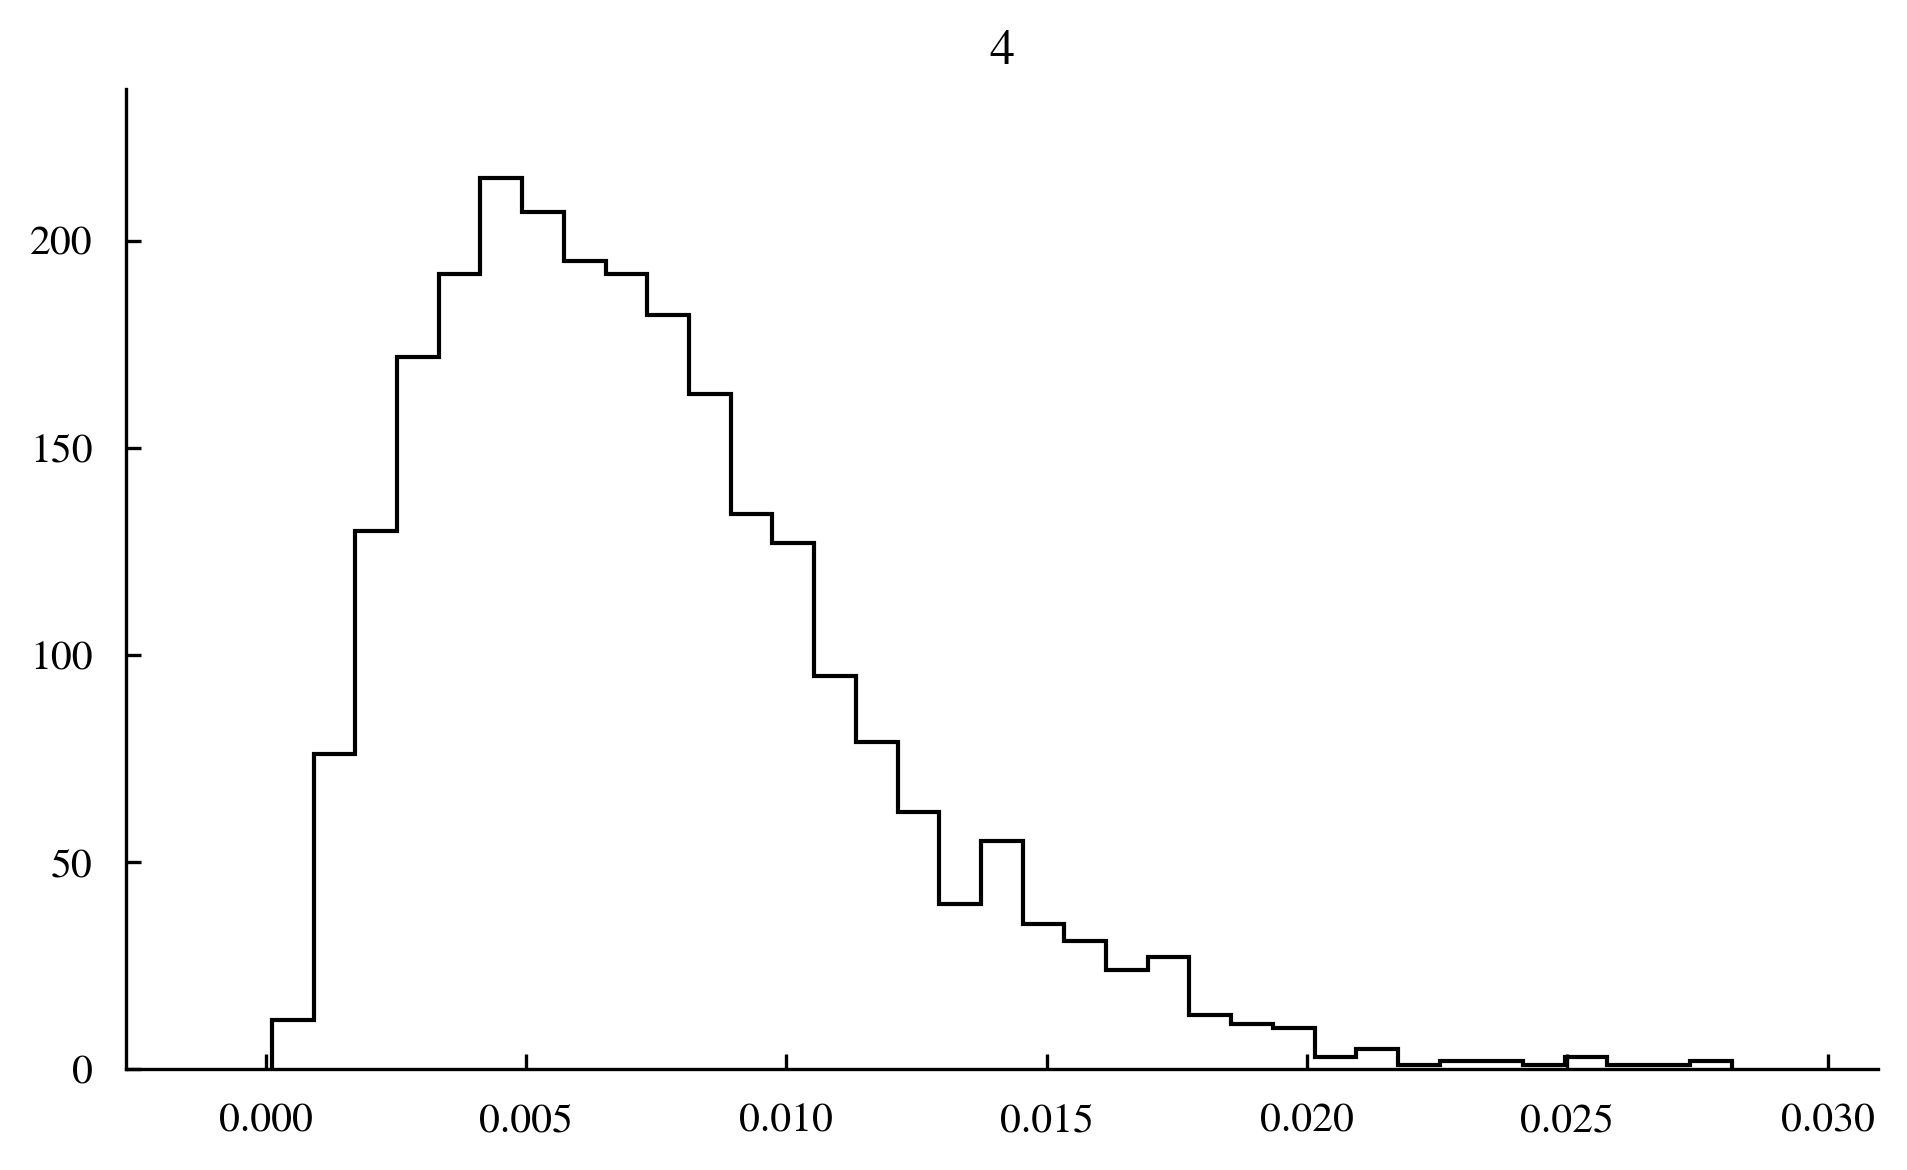

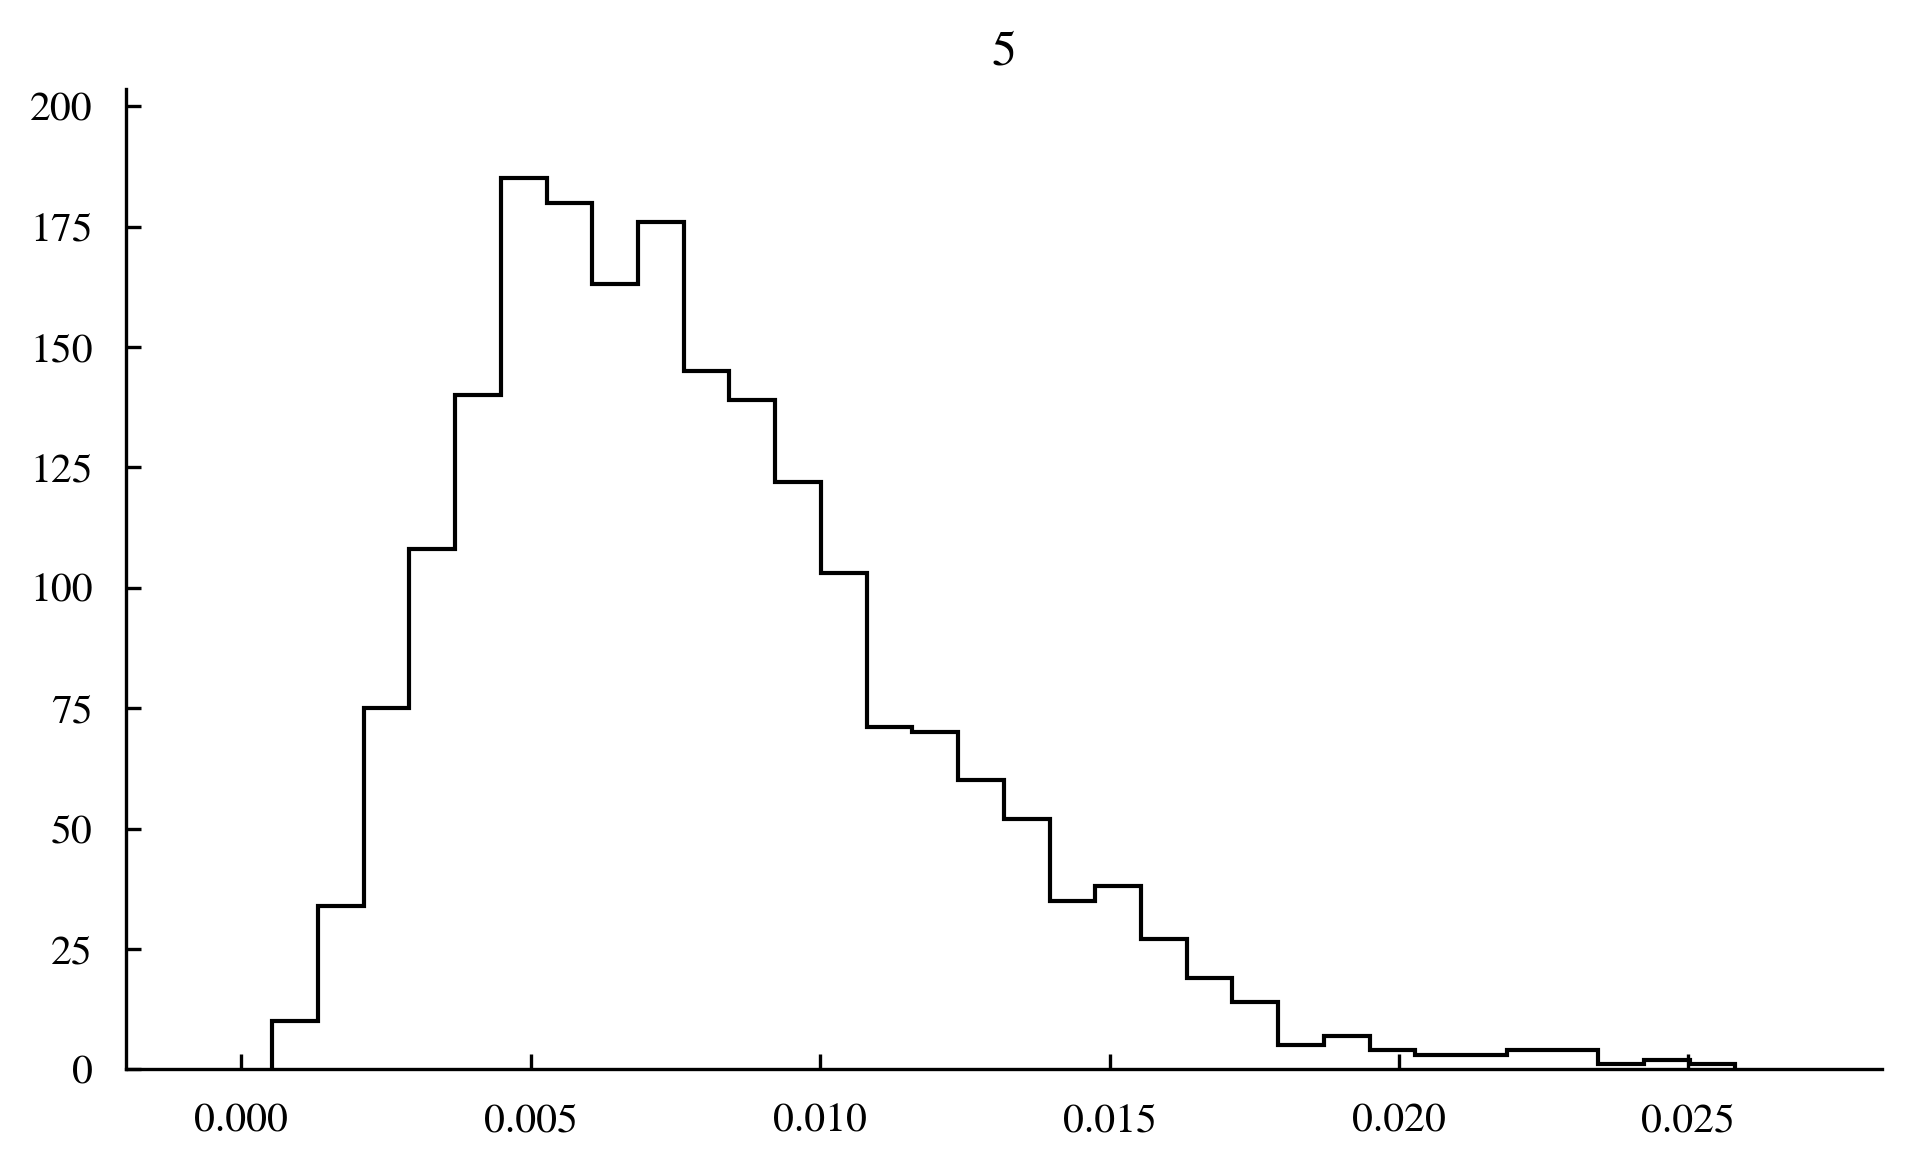

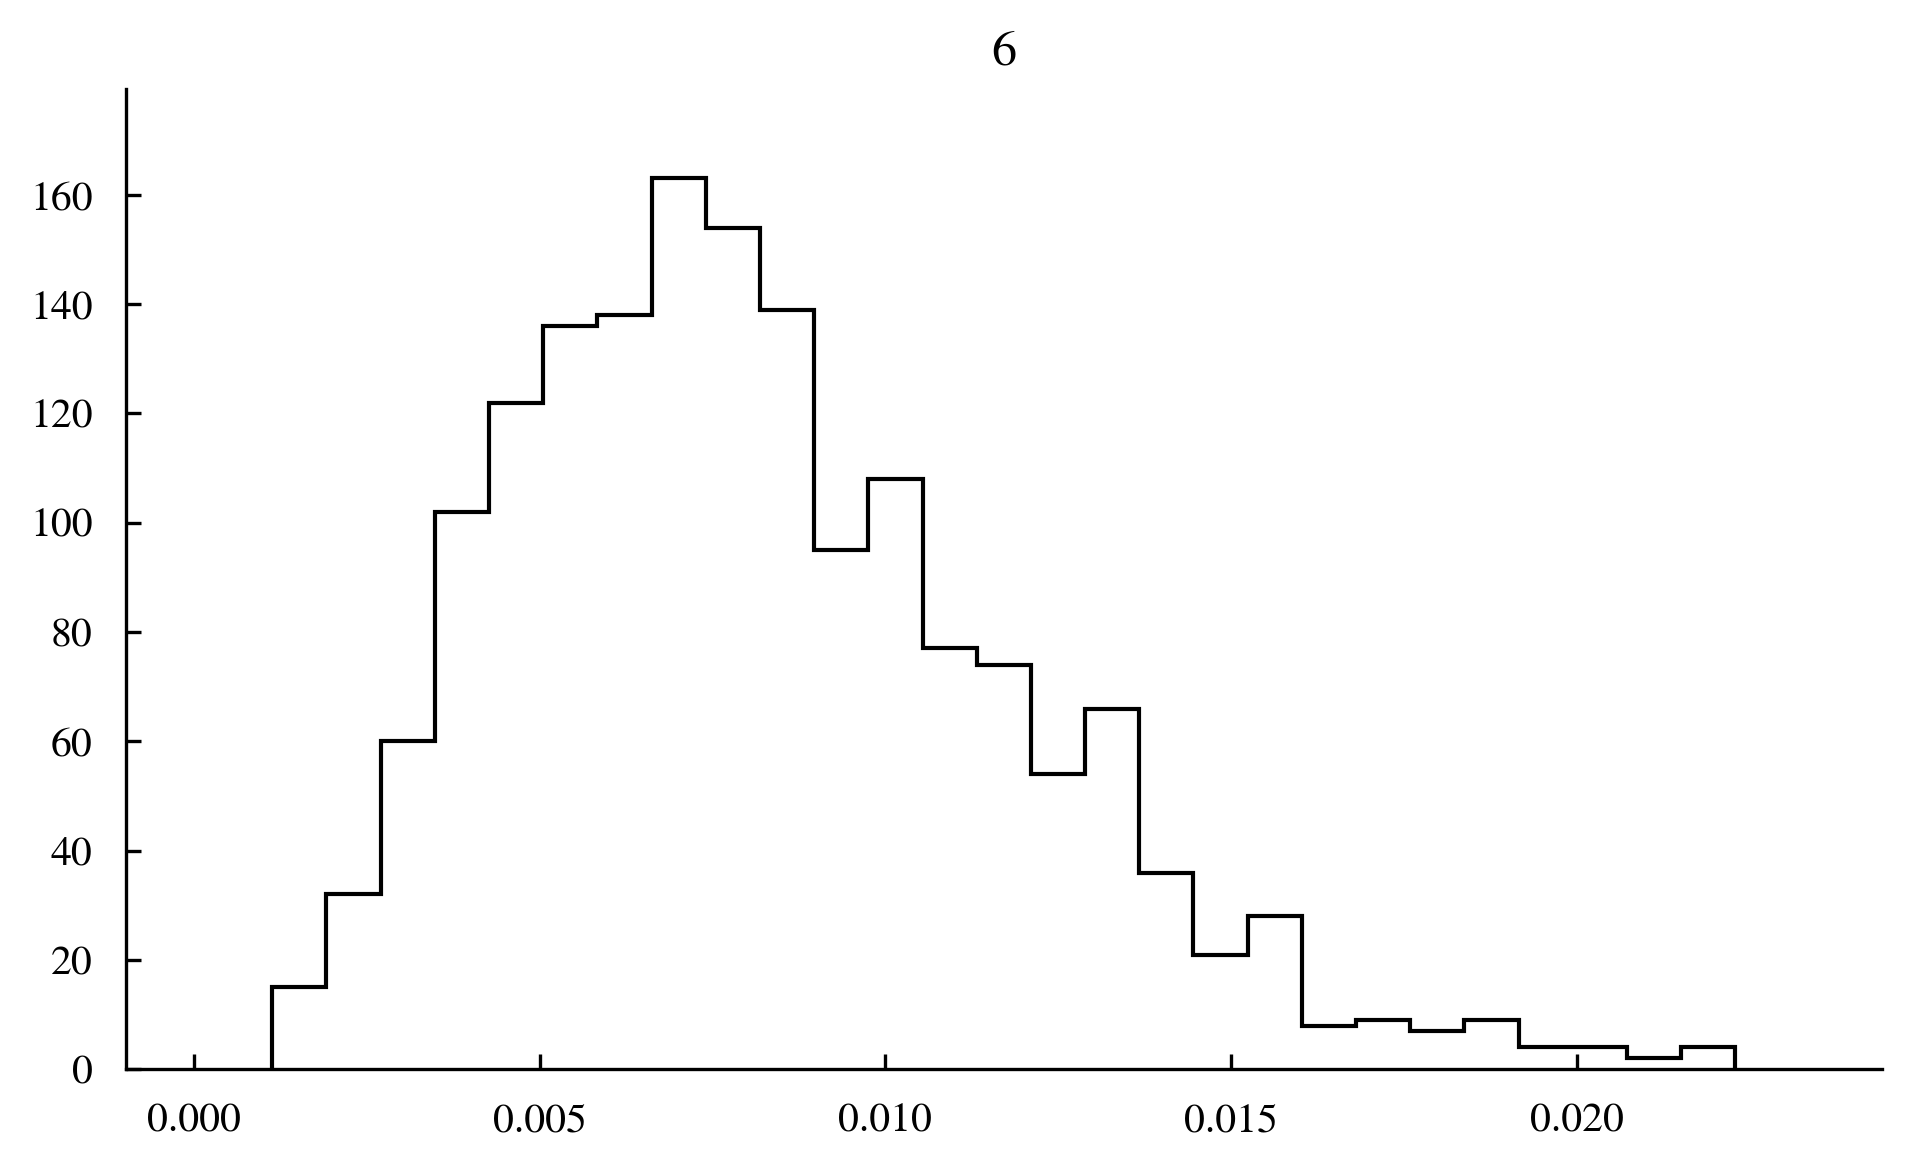

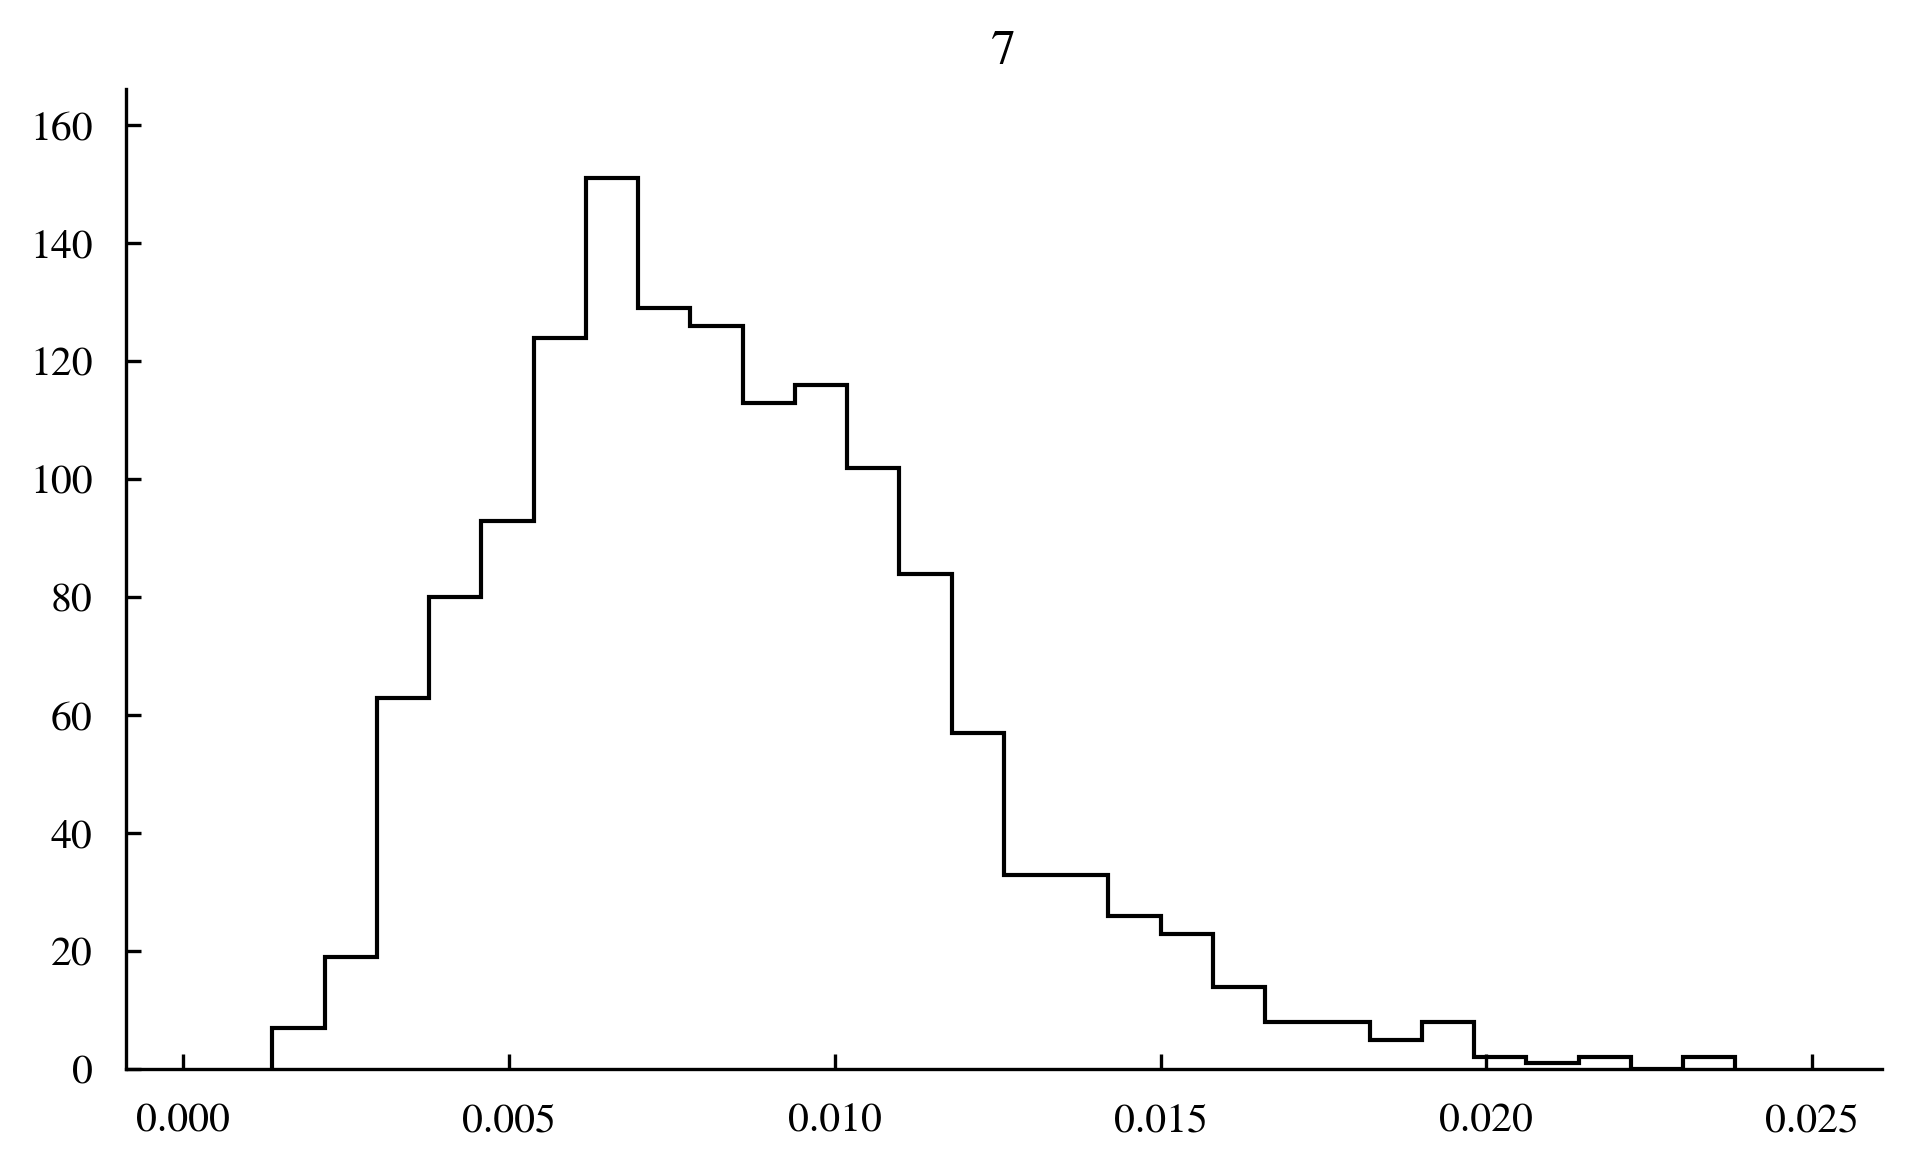

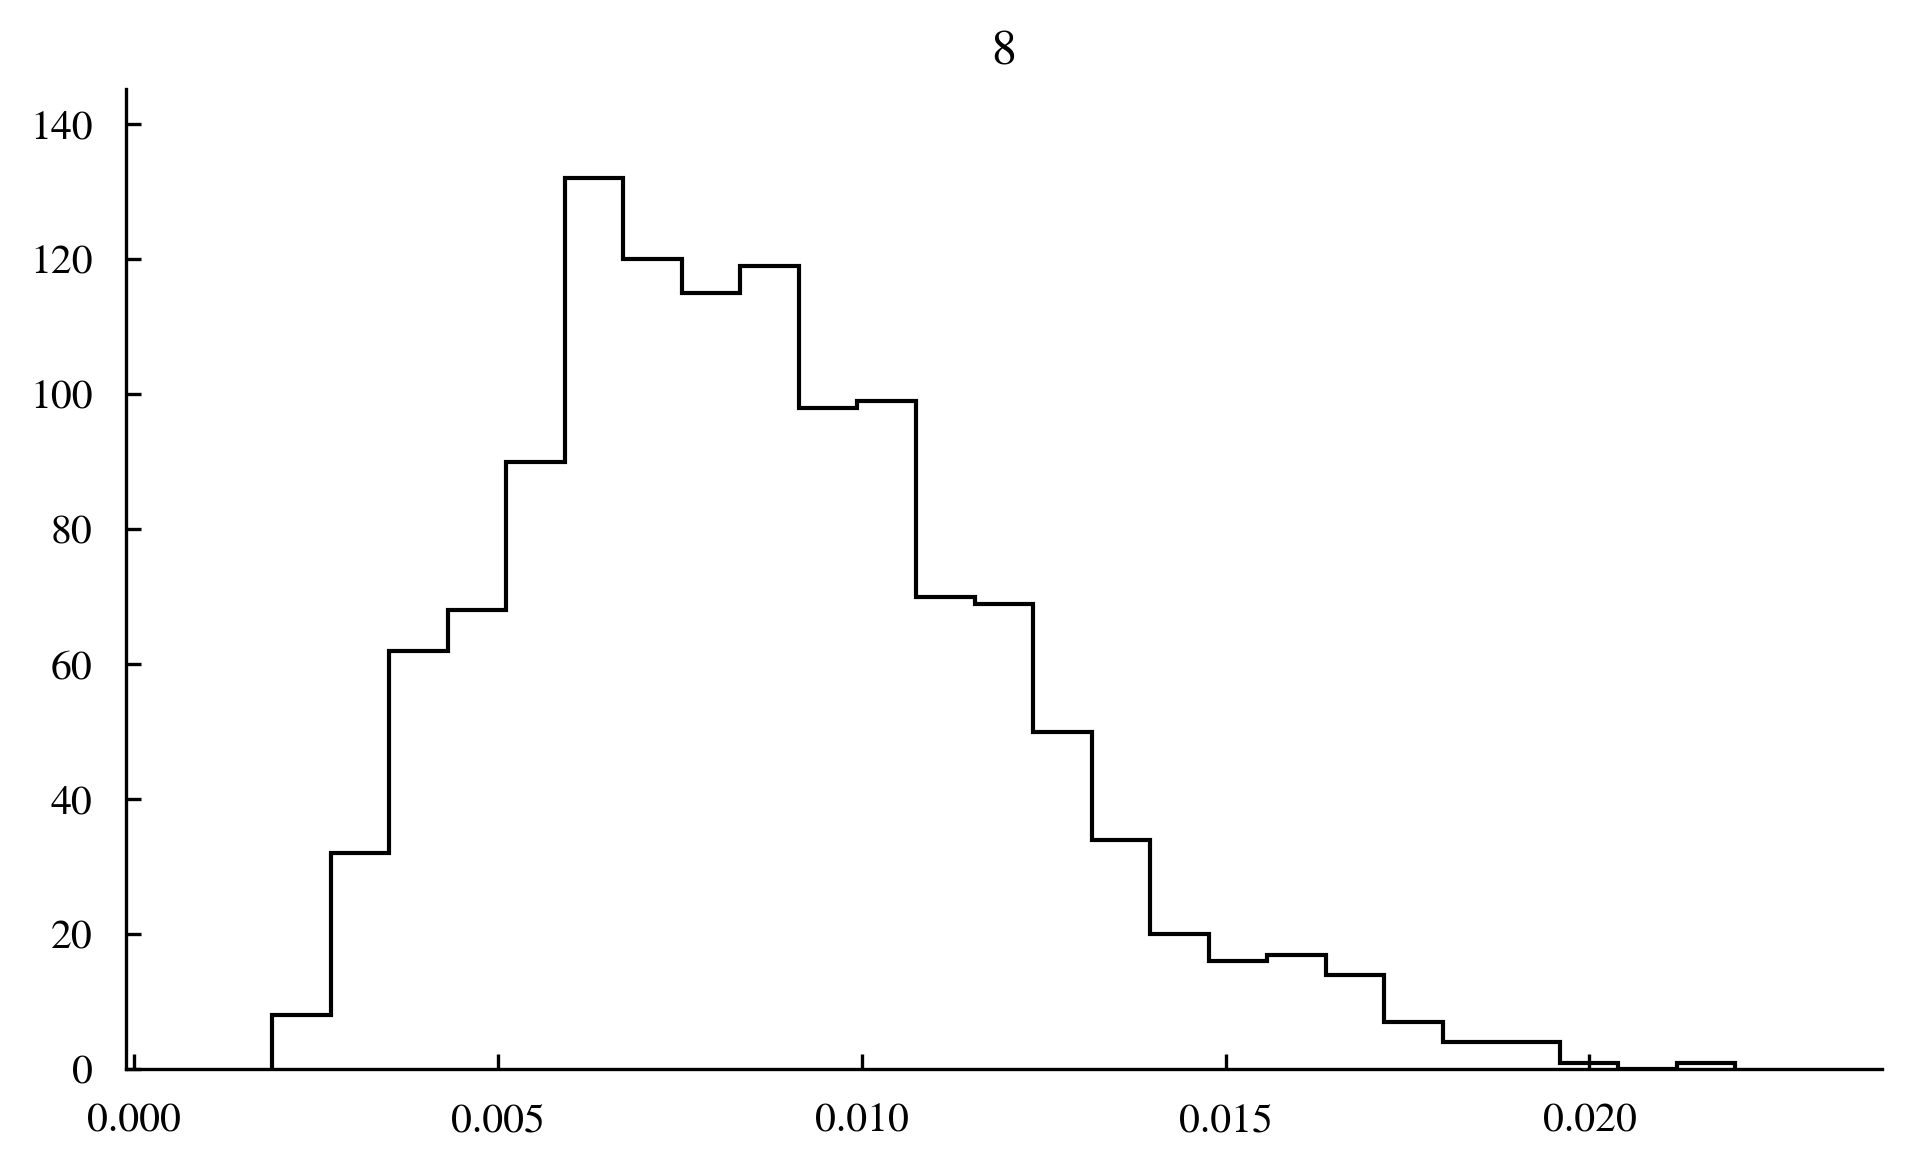

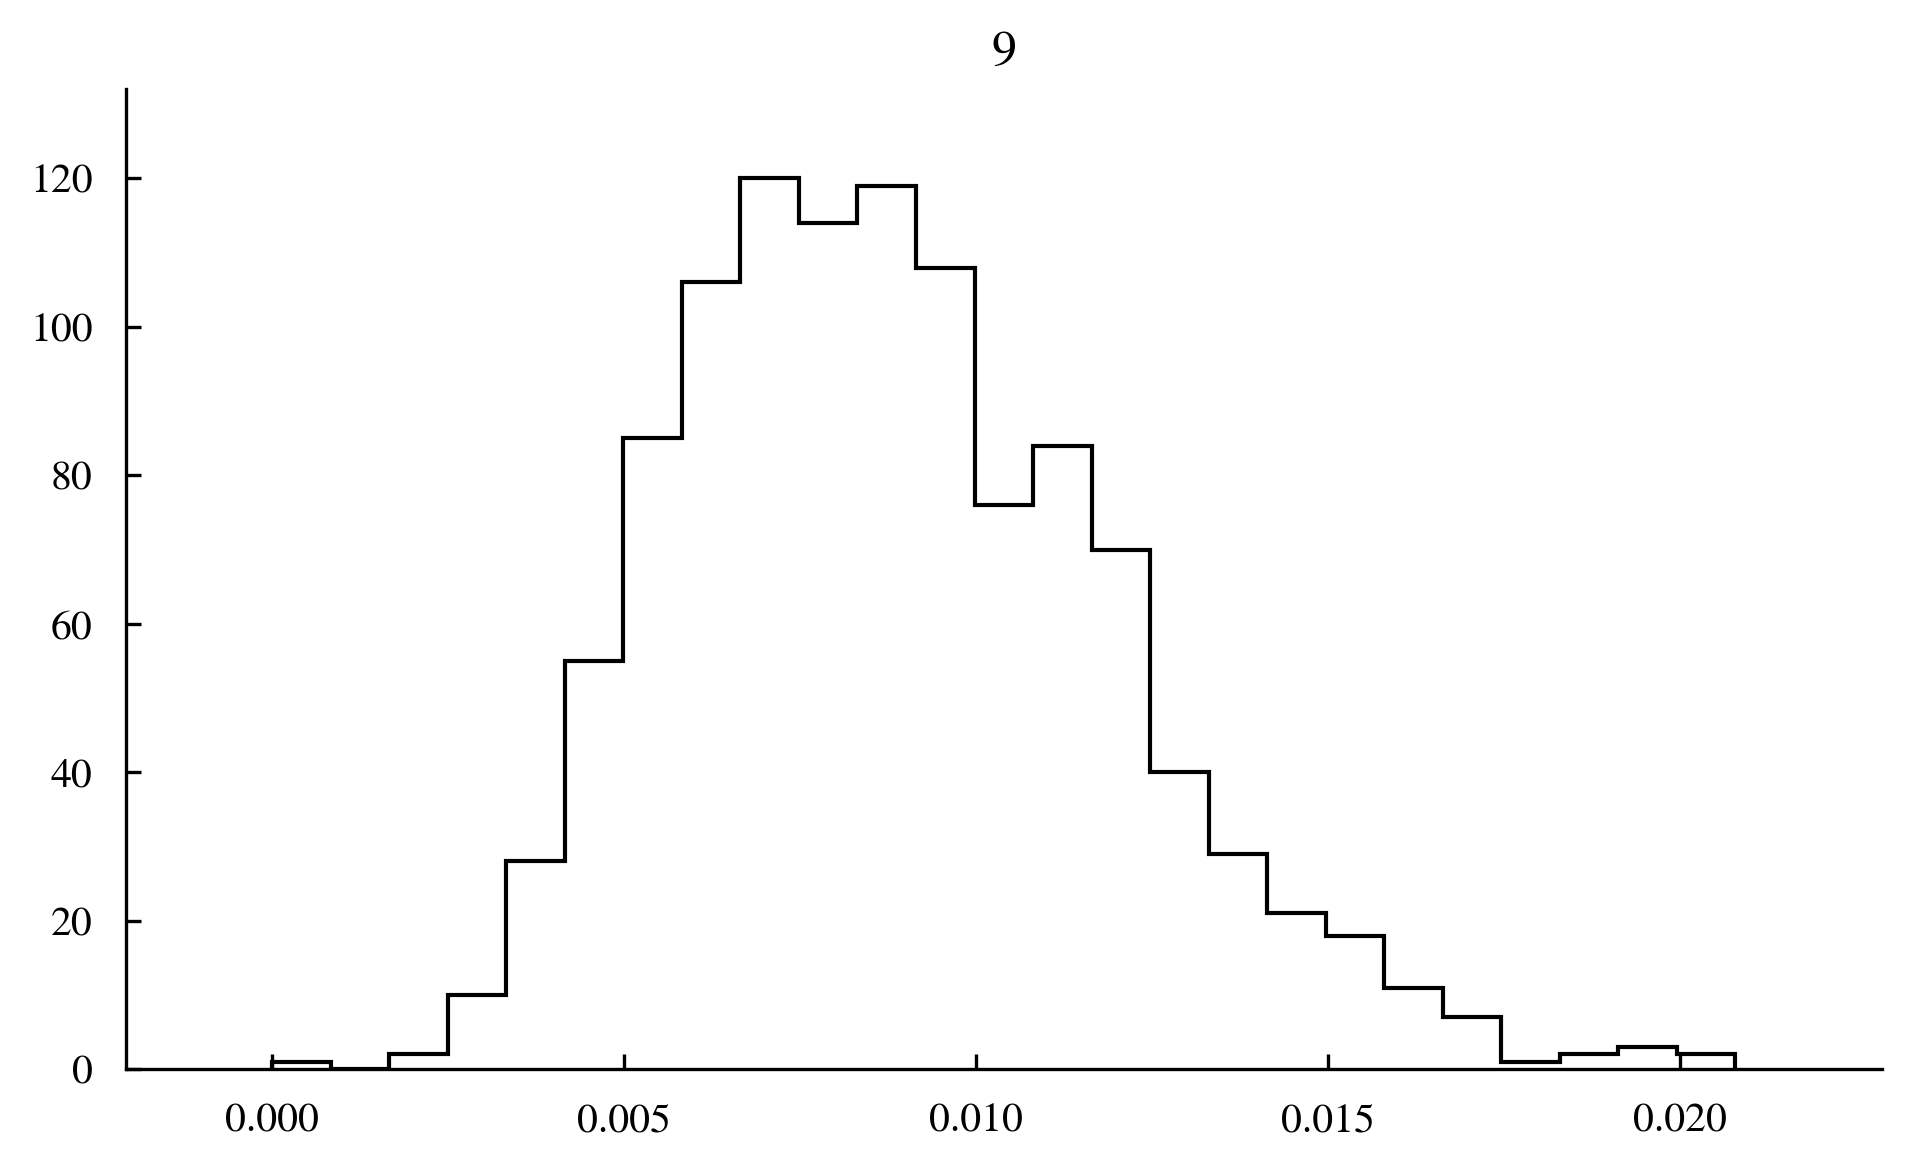

(array([1.019e+03, 8.460e+02, 7.850e+02, 7.120e+02, 6.320e+02, 6.020e+02,
        5.760e+02, 4.820e+02, 4.190e+02, 3.930e+02, 3.320e+02, 2.570e+02,
        2.910e+02, 2.560e+02, 2.410e+02, 1.840e+02, 1.940e+02, 1.550e+02,
        1.490e+02, 1.520e+02, 1.250e+02, 1.210e+02, 1.070e+02, 1.030e+02,
        6.800e+01, 6.900e+01, 5.600e+01, 5.000e+01, 5.900e+01, 5.100e+01,
        5.200e+01, 5.900e+01, 3.500e+01, 3.000e+01, 2.900e+01, 3.700e+01,
        2.600e+01, 2.100e+01, 2.600e+01, 1.500e+01, 2.300e+01, 1.600e+01,
        1.200e+01, 1.700e+01, 9.000e+00, 1.000e+01, 1.700e+01, 6.000e+00,
        1.100e+01, 7.000e+00, 5.000e+00, 4.000e+00, 4.000e+00, 5.000e+00,
        4.000e+00, 4.000e+00, 2.000e+00, 2.000e+00, 4.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 2.000e+00, 1.000e+00, 1.000e+00, 3.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 3.000e+00,
        1.000e+00, 0.000e+00, 1.000e+0

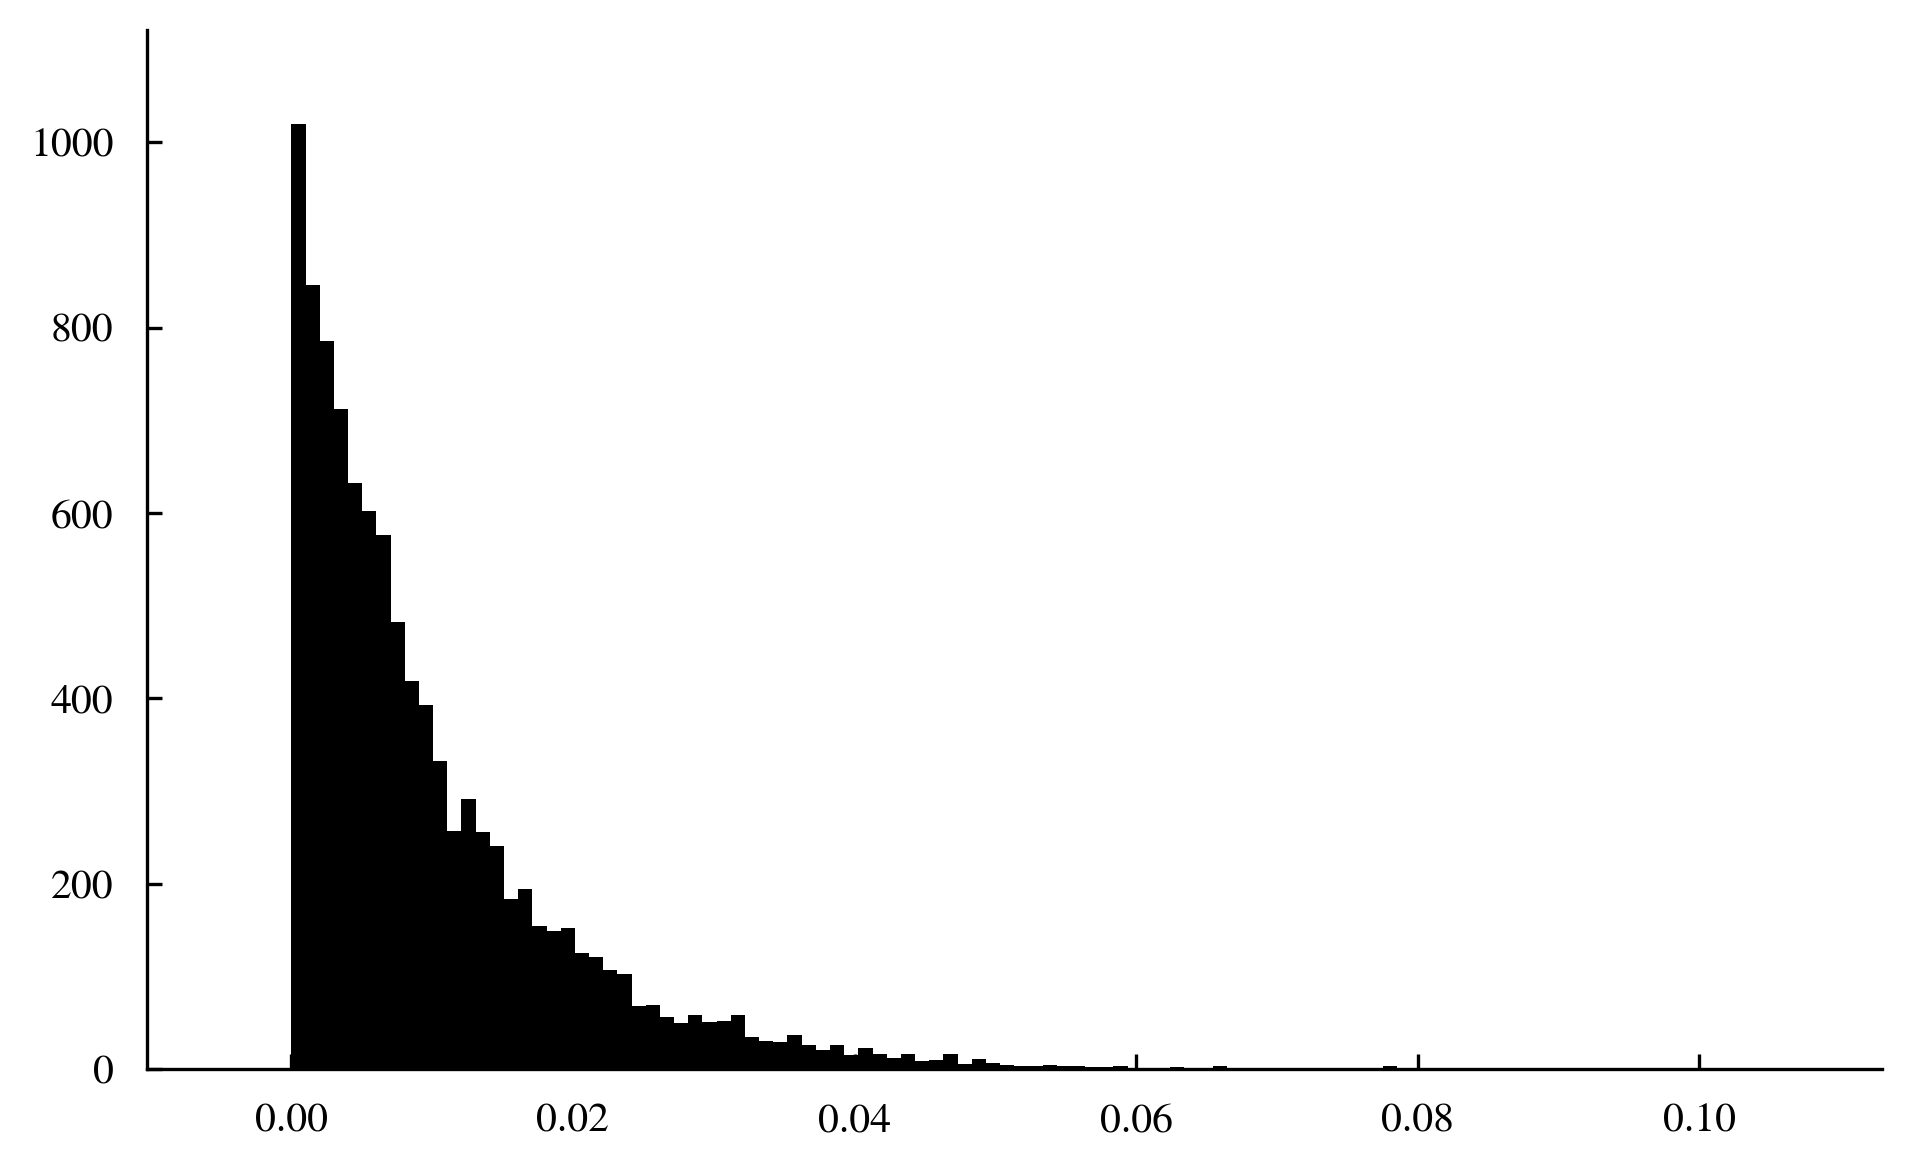

In [1]:
from scipy.stats import expon
import numpy as np
from math import factorial
import matplotlib.pyplot as plt


sim_sample = np.random.permutation(expon.rvs(0,.01,int(1e4)))

for mplet in range(3,10):
    fitted_args = list()
    for i in range(0,len(sim_sample),mplet):
        fitted_args.append(list(expon.fit(sim_sample[i:i+mplet])))
    fitted_args = np.array(fitted_args)
    plt.figure()
    plt.hist(fitted_args[:,1],histtype="step",bins="fd")
    plt.title(mplet)
    plt.show()
plt.figure()
plt.hist(sim_sample)